In [1]:
import os
import pandas as pd

# 获取桌面路径
desktop = os.path.join(os.path.expanduser("~"), "Desktop")

# 加载年度房价指数
price_path = os.path.join(desktop, "年度房价指数.xlsx")
df_price = pd.read_excel(price_path)

# 加载年度租金指数
rent_path = os.path.join(desktop, "年度租金指数.xlsx")
df_rent = pd.read_excel(rent_path)

# 保留需要的租金相关列
df_rent_filtered = df_rent[["Year", "ColdRent_Prophet", "ServiceCharge_Prophet"]]

# 合并两个数据集
df_merged = pd.merge(df_price, df_rent_filtered, on="Year", how="left")

# --- 以下为增长率计算 ---

# 去除非数值列（保留 Year 和所有指数列）
df_numeric = df_merged.drop(columns=[col for col in df_merged.columns if not pd.api.types.is_numeric_dtype(df_merged[col]) and col != "Year"])

# 设置 Year 为索引
df_numeric.set_index("Year", inplace=True)

# 计算增长率（t+1 / t）
growth_df = df_numeric.shift(-1) / df_numeric

# 去除最后一年
growth_df = growth_df[:-1]

# 恢复 Year 列
growth_df.reset_index(inplace=True)

# 保存增长率结果到桌面
growth_path = os.path.join(desktop, "price_rent_index.xlsx")
growth_df.to_excel(growth_path, index=False)

print(f"✅ 年度增长率已输出：{growth_path}")

✅ 年度增长率已输出：C:\Users\吴志宏\Desktop\price_rent_index.xlsx


In [3]:
import pandas as pd
import os

# 获取桌面路径
desktop = os.path.join(os.path.expanduser("~"), "Desktop")

# 读取主数据集 output.xlsx
main_path = os.path.join(desktop, "output.xlsx")
df_main = pd.read_excel(main_path)

# 读取包含邮政编码与房屋类型的 type.xlsx
type_path = os.path.join(desktop, "type.xlsx")
df_type = pd.read_excel(type_path)

# 标准化列名，合并数据
df_type = df_type.rename(columns={"L": "obj_zipCode", "KTU2023": "region_type"})

# 确保邮政编码是字符串，统一格式
df_main["obj_zipCode"] = df_main["obj_zipCode"].astype(str)
df_type["obj_zipCode"] = df_type["obj_zipCode"].astype(str)

# 合并数据（左连接）
df_merged = df_main.merge(df_type, on="obj_zipCode", how="left")

# 删除 RS 列（如果存在）
if "RS" in df_merged.columns:
    df_merged = df_merged.drop(columns=["RS"])

# 对缺失的 type，根据相邻 obj_zipCode 的 type 进行填充
# 方法：先按照 obj_zipCode 排序，然后用前后值填充
df_merged = df_merged.sort_values(by="obj_zipCode")
df_merged["region_type"] = df_merged["region_type"].fillna(method="ffill").fillna(method="bfill")

# 生成 house_type 列
df_merged["house_type"] = df_merged["obj_buildingType"].apply(
    lambda x: "Apartment" if x == "multi_family_house" else "Detachedhouse"
)

# 修改变量名
df_merged = df_merged.rename(columns={
    "obj_baseRent": "base_rent",
    "obj_serviceCharge": "service_charge",
    "Column1": "house_id",
    "obj_purchasePrice": "price",
    "obj_zipCode": "plz"
})

# 税法系数（小数形式）
tax_coefficient_map = {
    'Baden_Württemberg': 0.05,
    'Bayern': 0.035,
    'Berlin': 0.06,
    'Brandenburg': 0.065,
    'Bremen': 0.05,  # 你也可以选择 0.055
    'Hamburg': 0.055,
    'Hessen': 0.06,
    'Mecklenburg_Vorpommern': 0.06,
    'Niedersachsen': 0.05,
    'Nordrhein_Westfalen': 0.065,
    'Rheinland_Pfalz': 0.05,
    'Saarland': 0.065,
    'Sachsen': 0.055,
    'Sachsen_Anhalt': 0.05,
    'Schleswig_Holstein': 0.065,
    'Thüringen': 0.05
}

import pandas as pd
from sklearn.preprocessing import LabelEncoder
# Label Encoding（可用于模型训练）
le = LabelEncoder()
df_merged['obj_regio1_encoded'] = le.fit_transform(df_merged['obj_regio1'])

# 映射税法系数（小数形式）
df_merged['tax_transfer'] = df_merged['obj_regio1'].map(tax_coefficient_map)

# 检查是否存在未映射项
unmapped = df_merged[df_merged['tax_transfer'].isnull()]
if not unmapped.empty:
    print("⚠️ 有未映射的 obj_regio1 值：", unmapped['obj_regio1'].unique())

# 导出到桌面
output_path = os.path.join(desktop, "all_properties.xlsx")
df_merged.to_excel(output_path, index=False)

print("合并完成，已输出至桌面：all_properties")

合并完成，已输出至桌面：all_properties


In [2]:
import gym
from gym import spaces
from typing import List, Dict, Any
import copy
import gym
from gym import spaces
import numpy as np
import random
from typing import List, Dict, Any

class RentalYieldScorer:
    #定义一个方法 score，用于根据输入的房产列表 properties 和当前智能体状态 state，为每个房产计算一个分数（浮点数），
    # 返回的是所有房产的得分列表。
    def score(self,properties: List[Dict[str, Any]], state: Dict[str, Any]) -> List[float]:
        #初始化一个空列表，用来存储每个房产的得分。
        scores = []
        #从智能体的状态中获取其年收入。注意这里是 state["income"] 的第一个元素，说明收入是以数组形式保存的。
        agent_income = state.get("income")[0]
        affordability_ratio = 10  # 设定合理房价上限为年收入的 10 倍
        #遍历所有的候选房产
        for p in properties:
            price = p.get("price", 1.0)
            base_rent = p.get("base_rent", 0.0)
            service_charge = p.get("service_charge", 0.0)
            # 改动1

           # region_type = p.get("region_type",2.5)

            #计算每月总租金收入
            total_rent = base_rent + service_charge
            rental_yield = (total_rent * 12) / price if price > 0 else 0.0

            # 可负担性惩罚：超过上限的部分将降低得分
            max_affordable_price = agent_income * affordability_ratio
            if price > max_affordable_price:
                penalty = (price / max_affordable_price) ** 0.5  # 惩罚因子 sqrt 放缓梯度
                rental_yield /= penalty
            # 改动2
            # rental_yield = rental_yield*(1-region_type*0.1)
            scores.append(rental_yield)

        return scores

class RealEstateEnv(gym.Env):
    def __init__(
        self,
        all_properties: List[Dict[str, Any]],
        agent_profile: Dict[str, Any],
        growth_index: Dict[str, Dict[int, float]],
        max_inventory=10,
        candidate_top_k=20,
        scorer=None,
        reward_scale=10.0,
        cash_bonus_scale=5.0
    ):
        super().__init__()
        self.all_properties = all_properties

        self.agent_profile = agent_profile
        self.growth_index = growth_index
        self.max_inventory = max_inventory
        self.candidate_top_k = candidate_top_k
        self.max_year = 2035 - agent_profile["start_year"]

        self.start_year = agent_profile["start_year"]
        self.end_year = 2035

        self.scorer = scorer or RentalYieldScorer()
        self.reward_scale = reward_scale
        self.cash_bonus_scale = cash_bonus_scale

        self.action_space = spaces.Dict({
            "buy_index": spaces.Discrete(self.candidate_top_k + 1),
            "sell_house_ids": spaces.Box(0, 1e6, (max_inventory,), dtype=np.int32)
        })

        self.observation_space = spaces.Dict({
            "cash": spaces.Box(0, 1e10, (1,), dtype=np.float32),
            "initial_cash": spaces.Box(0, 1e10, (1,), dtype=np.float32),
            "income": spaces.Box(0, 1e6, (1,), dtype=np.float32),
            "age": spaces.Box(0, 100, (1,), dtype=np.int32),
            "marriage": spaces.Box(0, 1, (1,), dtype=np.int32),
            "children": spaces.Box(0, 10, (1,), dtype=np.int32),
            "start_year": spaces.Box(2000, 2100, (1,), dtype=np.int32),
            "current_year": spaces.Box(2000, 2100, (1,), dtype=np.int32),
            "year_remaining": spaces.Box(0, self.max_year, (1,), dtype=np.int32),
            "buy_candidates": spaces.Box(0, 1e6, (candidate_top_k, 10), dtype=np.float32),
            "portfolio": spaces.Box(0, 1e6, (max_inventory, 10), dtype=np.float32),
        })

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)

        self.year = 0
        self.current_year = self.start_year
        self.remaining_years = self.end_year - self.current_year

        self.agent_age = self.agent_profile["age"]
        self.marriage = self.agent_profile["marriage"]
        self.children = self.agent_profile["children"]
        self.income = self.agent_profile["income"]
        self.initial_cash = self.agent_profile["initial_cash"]
        self.cash = self.initial_cash
        self.portfolio = []
        self.current_market = []

        self._score_and_select_candidates()

        obs = self._get_obs()
        return obs, {}

    def step(self, action):
        TA_t = self._compute_total_assets()

        sell_ids = set(int(x) for x in action["sell_house_ids"] if x > 0)
        new_portfolio = []
        for p in self.portfolio:
            if p["house_id"] in sell_ids:
                self._sell_property(p)
            else:
                new_portfolio.append(p)
        self.portfolio = new_portfolio

        buy_index = int(action["buy_index"])
        max_idx = len(self.current_market) - 1
        buy_index = min(max(buy_index, -1), max_idx)

        if buy_index >= 0 and len(self.portfolio) < self.max_inventory:
            p = self.current_market[buy_index]
            if p["house_id"] not in set(x["house_id"] for x in self.portfolio):
                tax_transfer = p.get("tax_transfer")
                cost = p["price"] * (1 + tax_transfer)
                self.cash -= cost
                self.portfolio.append({
                    "house_id": p["house_id"],
                    "region_type": p["region_type"],
                    "house_type": p["house_type"],
                    "plz": p["plz"],
                    "purchase_price": p["price"],
                    "market_price": p["price"],
                    "base_rent": p["base_rent"],
                    "service_charge": p["service_charge"],
                    "purchase_date": self.current_year,
                    "aggregate_rent": 0.0
                })
            else:
                buy_index = -1

        self.year += 1
        self.current_year = self.start_year + self.year
        self.remaining_years = self.end_year - self.current_year
        self.agent_age += 1
        self.cash += self.income

        holding_tax_rate = 0.0164
        holding_tax_total = sum(p["market_price"] * holding_tax_rate for p in self.portfolio)
        self.cash -= holding_tax_total

        for p in self.portfolio:
            monthly_rent = p["base_rent"] + p["service_charge"]
            self.cash += monthly_rent * 12
            p["aggregate_rent"] += monthly_rent * 12

        self._update_market()
        self._score_and_select_candidates()

        TA_tp1 = self._compute_total_assets()
        cash_ratio_t = self.cash / (TA_t + 1e-6)
        cash_ratio_tp1 = self.cash / (TA_tp1 + 1e-6)

        reward_main = (TA_tp1 - TA_t) / (TA_t + 1e-6) * self.reward_scale
        reward_cash = (cash_ratio_tp1 - cash_ratio_t) * self.cash_bonus_scale
        reward = reward_main + reward_cash
        done = self.year >= self.max_year or self.agent_age >= 100
        return self._get_obs(), reward, done, {}

    def _sell_property(self, p):
        self.cash += p["market_price"]
        return True

    def _update_market(self):
        year = self.current_year

        for p in self.all_properties:
            house_type_str = "Apartment" if p["house_type"] == 0 else "Detached"
            region_type = p["region_type"]
            key = f"{house_type_str}_Type-{region_type}"

            price_index = self.growth_index.get(key, {}).get(year, 1.0)
            rent_index = self.growth_index.get("ColdRent_Prophet", {}).get(year, 1.0)
            service_index = self.growth_index.get("ServiceCharge_Prophet", {}).get(year, 1.0)

            if random.random() < 0.05:
                shock = random.uniform(0.95, 1.10)
                price_index *= shock

            p["price"] *= price_index
            p["base_rent"] *= rent_index
            p["service_charge"] *= service_index

        for p in self.portfolio:
            house_type_str = "Apartment" if p["house_type"] == 0 else "Detached"
            region_type = p["region_type"]
            key = f"{house_type_str}_Type-{region_type}"

            price_index = self.growth_index.get(key, {}).get(year, 1.0)
            rent_index = self.growth_index.get("ColdRent_Prophet", {}).get(year, 1.0)
            service_index = self.growth_index.get("ServiceCharge_Prophet", {}).get(year, 1.0)

            if random.random() < 0.05:
                shock = random.uniform(0.95, 1.10)
                price_index *= shock

            p["market_price"] *= price_index
            p["base_rent"] *= rent_index
            p["service_charge"] *= service_index

    def _score_and_select_candidates(self):
        current_house_ids = set(p["house_id"] for p in self.portfolio)
        candidate_props = [
            p for p in self.all_properties
            if p["house_id"] not in current_house_ids
            and p["price"] * (1+ p.get("tax_transfer")) <= self.cash
        ]

        scores = self.scorer.score(candidate_props, self._get_obs())
        sorted_props = [p for _, p in sorted(zip(scores, candidate_props), key=lambda x: -x[0])]
        self.current_market = sorted_props[:self.candidate_top_k]

    def _compute_total_assets(self):
        return self.cash + sum(p["market_price"] for p in self.portfolio)

    def _get_obs(self):
        return {
            "cash": np.array([self.cash], dtype=np.float32),
            "initial_cash": np.array([self.initial_cash], dtype=np.float32),
            "income": np.array([self.income], dtype=np.float32),
            "age": np.array([self.agent_age], dtype=np.int32),
            "marriage": np.array([self.marriage], dtype=np.int32),
            "children": np.array([self.children], dtype=np.int32),
            "start_year": np.array([self.start_year], dtype=np.int32),
            "current_year": np.array([self.current_year], dtype=np.int32),
            "year_remaining": np.array([self.remaining_years], dtype=np.int32),
            "buy_candidates": np.array(self._pad_props(self.current_market, self.candidate_top_k, mode="market"), dtype=np.float32),
            "portfolio": np.array(self._pad_props(self.portfolio, self.max_inventory, mode="portfolio"), dtype=np.float32),
        }

    def _pad_props(self, props, length, mode="market"):
        padded = []
        for p in props[:length]:
            if mode == "market":
                padded.append([
                    p.get("house_id", 0),
                    p.get("price", 0),
                    p.get("base_rent", 0) + p.get("service_charge", 0),
                    p.get("plz", 0),
                    p.get("region_type", 0),
                    p.get("house_type", 0),
                    0, 0, 0, 0
                ])
            elif mode == "portfolio":
                padded.append([
                    p.get("house_id", 0),
                    p.get("purchase_price", 0),
                    p.get("market_price", 0),
                    p.get("base_rent", 0) + p.get("service_charge", 0),
                    p.get("plz", 0),
                    p.get("purchase_date", 0),
                    p.get("aggregate_rent", 0),
                    p.get("region_type", 0),
                    p.get("house_type", 0),
                    0
                ])
        while len(padded) < length:
            padded.append([0.0] * 10)
        return padded

In [3]:
import torch.nn as nn
import itertools
import copy

class ActorCriticNet(nn.Module):
    def __init__(self, state_dim, buy_candidates_dim, portfolio_dim, hidden_dim=256):
        super().__init__()

        # 全局状态编码器
        self.state_encoder = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )

        # 买入候选编码器
        self.buy_encoder = nn.Sequential(
            nn.Linear(buy_candidates_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )

        # 持仓房产编码器
        self.portfolio_encoder = nn.Sequential(
            nn.Linear(portfolio_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )

        # Actor Heads
        self.buy_head = nn.Linear(hidden_dim, 1)     # 对每个候选房产打分
        self.sell_head = nn.Linear(hidden_dim, 1)    # 对每个持仓房产打分

        # Critic Head
        self.value_head = nn.Sequential(
            nn.Linear(3 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state_flat, buy_candidates, portfolio):
    # state 特征
        state_feat = self.state_encoder(state_flat)  # [B, H]

    # buy 特征
        buy_feat = self.buy_encoder(buy_candidates)  # [B, K, H]
        buy_scores = self.buy_head(buy_feat).squeeze(-1)  # [B, K]
        buy_feat_mean = buy_feat.mean(dim=1)  # [B, H]

    # portfolio 特征
        portfolio_feat = self.portfolio_encoder(portfolio)  # [B, M, H]
        sell_scores = self.sell_head(portfolio_feat).squeeze(-1)  # [B, M]
        port_feat_mean = portfolio_feat.mean(dim=1)  # [B, H]

    # 拼 joint_feat
        joint_feat = torch.cat([state_feat, buy_feat_mean, port_feat_mean], dim=-1)  # [B, 3H]

    # value
        value = self.value_head(joint_feat)  # [B, 1]
        return buy_scores, sell_scores, value


def generate_action_combinations(buy_scores, sell_scores, buy_indices, sell_ids, top_k,buy_candidates):

    combinations = []
    sell_ids = list(set(sell_ids))

    # 所有卖出子集组合
    for r in range(len(sell_ids) + 1):
        for sell_subset in itertools.combinations(sell_ids, r):
            # 不买，纯卖
            combinations.append({
                "buy_index": -1,
                "sell_house_ids": list(sell_subset)
            })

    # 对每个可买入房产，搭配所有可能的卖出组合
    for buy_idx in buy_indices:
        for r in range(len(sell_ids) + 1):
            for sell_subset in itertools.combinations(sell_ids, r):
                buy_house_id = int(buy_candidates[buy_idx][0].item())
                if buy_house_id in sell_subset:
                    continue

                combinations.append({
                    "buy_index": buy_idx,
                    "sell_house_ids": list(sell_subset)
                })

    def score_combo(combo):
        buy_score = 0.0
        if combo["buy_index"] < len(buy_scores):
            buy_score = buy_scores[combo["buy_index"]].item()

        sell_score = sum(
            sell_scores[sell_ids.index(sid)].item()
            for sid in combo["sell_house_ids"]
            if sid in sell_ids
        )
        return buy_score + sell_score

    sorted_combos = sorted(combinations, key=score_combo, reverse=True)
    return sorted_combos[:top_k]

def preprocess_obs(obs):
    scalar_keys = [
        "cash", "initial_cash", "income", "age",
        "marriage", "children", "start_year",
        "current_year", "year_remaining"
    ]
    state_flat = np.concatenate([obs[k] for k in scalar_keys], axis=0)
    state_flat = torch.tensor(state_flat, dtype=torch.float32).unsqueeze(0)

    buy_candidates = torch.tensor(obs["buy_candidates"], dtype=torch.float32).unsqueeze(0)
    portfolio = torch.tensor(obs["portfolio"], dtype=torch.float32).unsqueeze(0)

    return state_flat, buy_candidates, portfolio

In [4]:
from typing import Dict
import torch.nn.functional as F

class TrajectoryBuffer:
    def __init__(self):
        self.states = []
        self.buy_candidates = []
        self.portfolios = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []
        self.values = []

    def add(self, state, buy_candidates, portfolio, action, log_prob, reward, done, value):
        self.states.append(state)
        self.buy_candidates.append(buy_candidates)
        self.portfolios.append(portfolio)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.dones.append(done)
        self.values.append(value)

    def get(self):
        return {
            "states": torch.cat(self.states, dim=0),
            "buy_candidates": torch.cat(self.buy_candidates, dim=0),
            "portfolios": torch.cat(self.portfolios, dim=0),
            "actions": self.actions,
            "log_probs": torch.tensor(self.log_probs, dtype=torch.float32),
            "rewards": torch.tensor(self.rewards, dtype=torch.float32),
            "dones": torch.tensor(self.dones, dtype=torch.float32),
            "values": torch.cat(self.values, dim=0).squeeze(-1),  # [B]
        }

def sample_action(buy_scores, sell_scores, buy_candidates, buy_indices, sell_ids, temperature=1.0, action_top_k=5):
    """
    从给定得分中采样动作组合，返回 (动作组合, 对应 log 概率)。
    """

    combos = generate_action_combinations(
        buy_scores=buy_scores.squeeze(0),   # [K]
        sell_scores=sell_scores.squeeze(0), # [M]
        buy_indices=buy_indices,            # list of valid buy indices
        sell_ids=sell_ids,                  # list of valid sell house_ids
        top_k=action_top_k,
        buy_candidates=buy_candidates.squeeze(0)
    )


    # 组合得分
    scores = []
    for combo in combos:
        buy_score = 0.0
        if combo["buy_index"] < len(buy_scores.squeeze(0)):
            buy_score = buy_scores.squeeze(0)[combo["buy_index"]].item()

        sell_score = sum(
            sell_scores.squeeze(0)[sell_ids.index(sid)].item()
            for sid in combo["sell_house_ids"]
            if sid in sell_ids
        )
        scores.append(buy_score + sell_score)

    scores_tensor = torch.tensor(scores, dtype=torch.float32)
    probs = F.softmax(scores_tensor / temperature, dim=0)
    dist = torch.distributions.Categorical(probs)
    idx = dist.sample()

    return combos[idx.item()], dist.log_prob(idx)

def collect_trajectory(env, policy_net, max_steps=100, action_top_k=5, temperature=1.0):
    buffer = TrajectoryBuffer()
    obs, _ = env.reset()

    for step in range(max_steps):
        current_candidates = list(env.current_market)
        state_flat, buy_candidates, portfolio = preprocess_obs(obs)

        buy_indices = [i for i, p in enumerate(obs["buy_candidates"]) if p[0] > 0]
        sell_ids = [int(p[0]) for p in obs["portfolio"] if p[0] > 0]

        with torch.no_grad():
            buy_scores, sell_scores, value = policy_net(state_flat, buy_candidates, portfolio)

        action_dict, log_prob = sample_action(
            buy_scores, sell_scores,
            buy_indices=buy_indices,
            sell_ids=sell_ids,
            buy_candidates=buy_candidates.squeeze(0),
            action_top_k=action_top_k,
            temperature=temperature
        )

        if action_dict["buy_index"] >= 0 and action_dict["buy_index"] < len(env.current_market):
            buy_house_id = int(env.current_market[action_dict["buy_index"]]["house_id"])
        else:
            buy_house_id = -1
        # 构造动作 tensor
        padded_sell_ids = action_dict["sell_house_ids"] + [0] * (env.max_inventory - len(action_dict["sell_house_ids"]))
        action_tensor = {
            "buy_index": np.array([action_dict["buy_index"]]),
            "sell_house_ids": np.array(padded_sell_ids)
        }

        # 真正执行一步
        next_obs, reward, done, _ = env.step(action_tensor)


        portfolio_size = len(env.portfolio)
        # 打印
        curr_cash = next_obs["cash"][0]
        print(f"Step {step}: Buy: {buy_house_id}  Sell: {action_dict['sell_house_ids']}  "
              f"Cash: {curr_cash:.0f}  Portfolio size: {portfolio_size}")
        print(f"  Portfolio contents:")
        for p in obs["portfolio"]:
            if p[0] > 0:
                print(f"    - ID: {int(p[0])}")
        print()
        # 存入 buffer
        buffer.add(
            state=state_flat,
            buy_candidates=buy_candidates,
            portfolio=portfolio,
            action=action_dict,
            log_prob=log_prob.item(),
            reward=reward,
            done=done,
            value=value
        )

        obs = next_obs
        if done:
            break

    return buffer

In [5]:
def compute_gae(rewards, values, dones, gamma=0.99, lam=0.95):
    """
    基于 Generalized Advantage Estimation (GAE) 计算 advantage 和 returns

    Args:
        rewards: [T]
        values: [T]
        dones: [T]
    Returns:
        advantages: [T]
        returns: [T]
    """
    advantages = torch.zeros_like(rewards)
    gae = 0.0
    for t in reversed(range(len(rewards))):
        next_value = values[t + 1] if t + 1 < len(values) else 0.0
        delta = rewards[t] + gamma * next_value * (1 - dones[t]) - values[t]
        gae = delta + gamma * lam * (1 - dones[t]) * gae
        advantages[t] = gae

    returns = advantages + values
    return advantages, returns

def ppo_loss(buffer,
             policy_net,
             clip_eps=0.2,
             vf_coef=0.5,
             ent_coef=0.01,
             gamma=0.99,
             lam=0.95,
             loss_combo_top_k=5):
    """
    PPO 损失计算 + GAE
    """
    data = buffer

    state_flat = data["states"]            # [B, state_dim]
    buy_candidates = data["buy_candidates"]  # [B, K, 10]
    portfolios = data["portfolios"]        # [B, M, 10]

    # 前向传播新策略
    new_buy_scores, new_sell_scores, new_values = policy_net(state_flat, buy_candidates, portfolios)

    new_log_probs = []
    entropies = []

    for i, action in enumerate(data["actions"]):
        # 提取房产 ID（注意：是 float，需要转 int）
        buy_indices = [j for j, p in enumerate(buy_candidates[i]) if p[0].item() > 0]
        sell_ids = [int(p[0].item()) for p in portfolios[i] if p[0].item() > 0]

        # 当前状态下所有可能组合
        combos = generate_action_combinations(
            new_buy_scores[i], new_sell_scores[i],
            buy_indices=buy_indices,
            sell_ids=sell_ids,
            top_k=loss_combo_top_k,
            buy_candidates=buy_candidates[i]
        )

        this_action = {"buy_index": action["buy_index"], "sell_house_ids": action["sell_house_ids"]}
        if this_action not in combos:
            combos = [this_action] + combos

        scores = []
        for combo in combos:
            # 计算组合得分（buy_score + sum(sell_scores)）
            buy_score = 0.0
            buy_index = combo["buy_index"]
            if buy_index >= 0 and buy_index < new_buy_scores[i].shape[0]:
                buy_score = new_buy_scores[i][buy_index].item()

            sell_score = 0.0
            for sid in combo["sell_house_ids"]:
                if sid in sell_ids:
                    idx = sell_ids.index(sid)
                    sell_score += new_sell_scores[i][idx].item()

            scores.append(buy_score + sell_score)

        # 构造策略分布并取 log_prob
        scores_tensor = torch.tensor(scores, dtype=torch.float32)
        probs = F.softmax(scores_tensor, dim=0)
        dist = torch.distributions.Categorical(probs)

        # 匹配当前动作在所有组合中的位置
        action_idx = next(
            j for j, c in enumerate(combos)
            if c["buy_index"] == action["buy_index"]
            and c["sell_house_ids"] == action["sell_house_ids"]
        )

        new_log_probs.append(dist.log_prob(torch.tensor(action_idx)))
        entropies.append(dist.entropy())

    new_log_probs = torch.stack(new_log_probs)  # [B]
    entropies = torch.stack(entropies)          # [B]

    # ✅ GAE 计算
    advantages, returns = compute_gae(
        data["rewards"], data["values"], data["dones"],
        gamma=gamma, lam=lam
    )
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    returns = torch.clamp(returns, -5.0, 5.0)

    # ✅ PPO 损失项
    old_log_probs = data["log_probs"]  # [B]
    ratio = torch.exp(new_log_probs - old_log_probs)
    surr1 = ratio * advantages
    surr2 = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps) * advantages
    actor_loss = -torch.min(surr1, surr2).mean()

    critic_loss = F.mse_loss(new_values.squeeze(-1), returns)
    entropy_bonus = entropies.mean()

    total_loss = actor_loss + vf_coef * critic_loss - ent_coef * entropy_bonus

    return total_loss, actor_loss.item(), critic_loss.item(), entropy_bonus.item()

In [6]:
import random
import torch.optim as optim
from tqdm import trange
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

def generate_random_agent_profile(start_year_range=(2015, 2025),
                                  age_range=(22, 78),
                                  income_range=(50000, 150000),
                                  cash_multiplier_range=(1.0, 3.0),
                                  max_children=3,
                                  random_seed: int = None) -> Dict[str, Any]:
    rng = random.Random(random_seed) if random_seed is not None else random

    start_year = rng.randint(*start_year_range)
    age = rng.randint(*age_range)
    marriage = rng.randint(0, 1)

    if age <= 25:
        children = rng.choices([0, 1, 2], weights=[0.6, 0.3, 0.1])[0]
    elif age <= 35:
        children = rng.choices([0, 1, 2, 3], weights=[0.3, 0.4, 0.25, 0.05])[0]
    elif age <= 50:
        children = rng.choices([0, 1, 2, 3], weights=[0.1, 0.25, 0.45, 0.2])[0]
    else:
        children = rng.choices([1, 2, 3], weights=[0.2, 0.5, 0.3])[0]

    min_income, max_income = income_range
    income_range_size = max_income - min_income

    if age <= 30:
        income_position = rng.uniform(0.0, 0.4)
    elif age <= 45:
        income_position = rng.uniform(0.6, 1.0)
    elif age <= 60:
        income_position = rng.uniform(0.5, 0.9)
    else:
        income_position = rng.uniform(0.2, 0.7)

    income = int(min_income + income_range_size * income_position)
    cash_multiplier = rng.uniform(*cash_multiplier_range)
    initial_cash = int(income * cash_multiplier)

    return {
        "start_year": start_year,
        "age": age,
        "marriage": marriage,
        "children": children,
        "income": income,
        "initial_cash": initial_cash
    }

class PPOTrainer:
    def __init__(self,
                 property_pool,
                 growth_index,
                 policy_net,
                 scorer=None,
                 reward_scale=10.0,
                 cash_bonus_scale=5.0,
                 candidate_top_k=20,
                 action_top_k=5,
                 loss_combo_top_k=5,
                 max_inventory=10,
                 epochs=10,
                 max_steps=200,
                 batch_size=64,
                 lr=3e-4,
                 clip_eps=0.2,
                 num_eval_agents=5,
                 eval_interval=10):

        self.property_pool = property_pool
        self.growth_index = growth_index
        self.policy_net = policy_net
        self.scorer = scorer or RentalYieldScorer()
        self.reward_scale = reward_scale
        self.cash_bonus_scale = cash_bonus_scale

        self.max_inventory = max_inventory
        self.candidate_top_k = candidate_top_k
        self.action_top_k = action_top_k
        self.loss_combo_top_k = loss_combo_top_k
        self.epochs = epochs
        self.max_steps = max_steps
        self.batch_size = batch_size
        self.clip_eps = clip_eps

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)

        self.num_eval_agents = num_eval_agents
        self.eval_interval = eval_interval
        self.eval_agents = [generate_random_agent_profile() for _ in range(num_eval_agents)]
        self.eval_history = [[] for _ in range(num_eval_agents)]

    def train(self, num_iterations=100):
        for iteration in trange(num_iterations, desc="Training PPO"):

            # 生成 agent 配置
            agent_profile = generate_random_agent_profile()

            # 初始化环境
            env = RealEstateEnv(
                all_properties=[p.copy() for p in self.property_pool],
                agent_profile=agent_profile,
                growth_index=self.growth_index,
                max_inventory=self.max_inventory,
                candidate_top_k=self.candidate_top_k,
                scorer=self.scorer,
                reward_scale=self.reward_scale,
                cash_bonus_scale=self.cash_bonus_scale
            )

            # 收集一条完整 trajectory
            buffer = collect_trajectory(
                env,
                self.policy_net,
                max_steps=self.max_steps,
                action_top_k=self.action_top_k,
                temperature=1.0,
            )

            # 取出 buffer 内容
            data = buffer.get()
            N = len(data["rewards"])
            batch_size = min(self.batch_size, N)

            # 多轮训练 epoch
            for epoch in range(self.epochs):
                indices = np.arange(N)
                np.random.shuffle(indices)

                for start in range(0, N, batch_size):
                    end = start + batch_size
                    mb_idx = indices[start:end]

                    # 构造 mini-batch 数据
                    mini_data = {
                        key: (val[mb_idx] if isinstance(val, torch.Tensor)
                              else [val[i] for i in mb_idx])
                        for key, val in data.items()
                    }

                    total_loss, actor_loss, critic_loss, entropy = ppo_loss(
                        mini_data,
                        self.policy_net,
                        clip_eps=self.clip_eps,
                        vf_coef=0.5,
                        ent_coef=0.01,
                        gamma=0.99,
                        lam=0.95,
                        loss_combo_top_k=self.loss_combo_top_k
                    )

                    self.optimizer.zero_grad()
                    total_loss.backward()
                    self.optimizer.step()

            # 收集最后状态数据
            rewards = buffer.rewards
            total_reward = sum(rewards)
            avg_reward = total_reward / len(rewards)

            last_obs = env._get_obs()
            final_cash = last_obs["cash"].item()
            final_assets = final_cash + sum([p[2] for p in last_obs["portfolio"] if p[0] > 0])
            inventory_size = sum(1 for p in last_obs["portfolio"] if p[0] > 0)

            # 打印训练日志
            print(f"[Iter {iteration}] "
                  f"Loss: {total_loss.item():.4f} | Actor: {actor_loss:.4f} | Critic: {critic_loss:.4f} | Entropy: {entropy:.4f} | "
                  f"AvgReward: {avg_reward:.2f} | FinalAsset: {final_assets:,.0f} | Inventory: {inventory_size}")

            if (iteration + 1) % self.eval_interval == 0:
                print(f"\n[Eval @ Iter {iteration}]")
                for i, agent_profile in enumerate(self.eval_agents):
                    eval_env = RealEstateEnv(
                        all_properties=[p.copy() for p in self.property_pool],
                        agent_profile=agent_profile,
                        growth_index=self.growth_index,
                        max_inventory=self.max_inventory,
                        candidate_top_k=self.candidate_top_k,
                        scorer=self.scorer,
                        reward_scale=self.reward_scale,
                        cash_bonus_scale=self.cash_bonus_scale
                    )

                    eval_buffer = collect_trajectory(
                        eval_env,
                        self.policy_net,
                        max_steps=self.max_steps,
                        action_top_k=self.action_top_k,
                        temperature=1.0
                    )

                    eval_rewards = eval_buffer.rewards
                    eval_total_reward = sum(eval_rewards)
                    eval_avg_reward = eval_total_reward / len(eval_rewards)
                    self.eval_history[i].append(eval_avg_reward)

                    print(f"[Eval Agent {i}] AvgReward: {eval_avg_reward:.2f}")

        # 训练结束，绘图
        self.plot_eval_history()

In [7]:
import pandas as pd
import os
import numpy as np
import torch


# 桌面路径（适配不同用户）
desktop = os.path.join(os.path.expanduser("~"), "Desktop")

# 路径拼接
property_path = os.path.join(desktop, "all_properties.xlsx")
index_path = os.path.join(desktop, "price_rent_index.xlsx")

# 加载 Excel
property_df = pd.read_excel(property_path)
index_df = pd.read_excel(index_path)

property_pool = property_df.to_dict(orient="records")

growth_index = {}

for col in index_df.columns:
    if col != "Year":
        growth_index[col] = dict(zip(index_df["Year"], index_df[col]))

HOUSE_TYPE_MAP = {
    "Apartment": 0,
    "Detachedhouse": 1
}

for p in property_pool:
    p["house_type"] = HOUSE_TYPE_MAP.get(p["house_type"])


In [ ]:
state_dim = 9  # scalar keys
buy_candidates_dim = 10
portfolio_dim = 10

policy_net = ActorCriticNet(state_dim, buy_candidates_dim, portfolio_dim)

trainer = PPOTrainer(
    property_pool=property_pool,
    growth_index=growth_index,
    policy_net=policy_net,
    scorer=RentalYieldScorer(),
    reward_scale=10.0,
    cash_bonus_scale=0.1,
    max_steps=200,
    lr=1e-4,
    clip_eps=0.3,
    num_eval_agents=5,
    eval_interval=10
)

trainer.train(num_iterations=200)

In [10]:
# 保存模型
torch.save(trainer.policy_net.state_dict(), "ppo_policy.pth")

In [11]:
# 1️⃣ 重新初始化 policy_net
state_dim = 9
buy_candidates_dim = 10
portfolio_dim = 10

policy_net = ActorCriticNet(state_dim, buy_candidates_dim, portfolio_dim)

# 2️⃣ 加载模型参数
policy_net.load_state_dict(torch.load("ppo_policy.pth", map_location="cpu"))
policy_net.eval()  # 切换到 eval 模式，关闭 dropout / layernorm update

# 3️⃣ 定义 Baseline 策略 Runner
def run_baseline_hold_to_end(env, policy_net, agent_seed=25, top_k=1, verbose=False):
    obs, _ = env.reset()

    state_flat, buy_candidates, portfolio = preprocess_obs(obs)
    buy_indices = [i for i, p in enumerate(obs["buy_candidates"]) if p[0] > 0]

    with torch.no_grad():
        buy_scores, sell_scores, value = policy_net(state_flat, buy_candidates, portfolio)

    sorted_buy = sorted(
        zip(buy_indices, buy_scores.squeeze(0).cpu().numpy()),
        key=lambda x: -x[1]
    )

    # 选出 top-1
    top_buy_idx = sorted_buy[0][0]

    # 一次性只买一套（env 本身只能一步买一套）
    action_tensor = {
        "buy_index": np.array([top_buy_idx]),
        "sell_house_ids": np.array([0] * env.max_inventory)
    }
    obs, reward, done, _ = env.step(action_tensor)

    if verbose:
        bought_id = int(env.current_market[top_buy_idx]["house_id"])
        print(f"Buy house {bought_id}, cash: {obs['cash'][0]:,.0f}")

    # 后续年度持有，不买不卖
    rewards = []
    while not done:
        action_tensor = {
            "buy_index": np.array([-1]),
            "sell_house_ids": np.array([0] * env.max_inventory)
        }
        obs, reward, done, _ = env.step(action_tensor)
        rewards.append(reward)

        if verbose:
            print(f"Year {env.current_year}, cash: {obs['cash'][0]:,.0f}, reward: {reward:.2f}")

    # 结果统计
    final_cash = obs["cash"][0]
    final_assets = final_cash + sum([p[2] for p in obs["portfolio"] if p[0] > 0])
    inventory_size = sum(1 for p in obs["portfolio"] if p[0] > 0)
    total_reward = sum(rewards)
    avg_reward = total_reward / len(rewards) if len(rewards) > 0 else 0.0

    print(f"\n🎯 评估结果（Agent Seed={agent_seed})")
    print(f"Avg Reward: {avg_reward:.2f}")
    print(f"Final Assets: {final_assets:,.0f}")
    print(f"Inventory Size: {inventory_size}")

    return {
        "avg_reward": avg_reward,
        "final_assets": final_assets,
        "inventory_size": inventory_size,
        "rewards": rewards
    }


# 4️⃣ 运行 baseline
agent_profile = generate_random_agent_profile(random_seed=35)

env = RealEstateEnv(
    all_properties=[p.copy() for p in property_pool],
    agent_profile=agent_profile,
    growth_index=growth_index,
    max_inventory=10,
    candidate_top_k=20,
    scorer=RentalYieldScorer(),
    reward_scale=10.0,
    cash_bonus_scale=0.1
)


# 然后传入 policy_net
baseline_result = run_baseline_hold_to_end(
    env,
    policy_net,
    agent_seed=35,
    top_k=1,
    verbose=True
)

C:\Users\huang\AppData\Local\Temp\ipykernel_30288\4035774597.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load("ppo_policy.pth", map_

Buy house 43117, cash: 372,314
Year 2025, cash: 523,327, reward: 3.95
Year 2026, cash: 674,495, reward: 2.82
Year 2027, cash: 825,813, reward: 2.21
Year 2028, cash: 977,257, reward: 1.80
Year 2029, cash: 1,128,835, reward: 1.52
Year 2030, cash: 1,280,540, reward: 1.32
Year 2031, cash: 1,432,368, reward: 1.17
Year 2032, cash: 1,584,293, reward: 1.04
Year 2033, cash: 1,736,324, reward: 0.95
Year 2034, cash: 1,888,458, reward: 0.86
Year 2035, cash: 2,040,684, reward: 0.80

🎯 评估结果（Agent Seed=35)
Avg Reward: 1.68
Final Assets: 2,046,720
Inventory Size: 1


In [13]:
# 调用模型并且跑出
import torch
from copy import deepcopy

# 重新构造 policy_net（和训练时一致的参数）
state_dim = 9
buy_candidates_dim = 10
portfolio_dim = 10
policy_net = ActorCriticNet(state_dim, buy_candidates_dim, portfolio_dim)

# 加载训练好的模型参数
policy_net.load_state_dict(torch.load("ppo_policy.pth", map_location=torch.device("cpu")))
policy_net.eval()
print("✅ 已加载训练好的策略模型")

# 创建一个随机种子为 25 的 agent
agent_profile = generate_random_agent_profile(random_seed=35)

# 初始化环境
eval_env = RealEstateEnv(
    all_properties=[deepcopy(p) for p in property_pool],
    agent_profile=agent_profile,
    growth_index=growth_index,
    max_inventory=10,
    candidate_top_k=20,
    scorer=RentalYieldScorer(),
    reward_scale=10.0,
    cash_bonus_scale=0.1
)

# 使用训练好的模型执行 rollout
eval_buffer = collect_trajectory(
    eval_env,
    policy_net,
    max_steps=200,
    action_top_k=5,
    temperature=1.0
)

# 统计并打印结果
eval_rewards = eval_buffer.rewards
total_reward = sum(eval_rewards)
avg_reward = total_reward / len(eval_rewards)

final_obs = eval_env._get_obs()
final_cash = final_obs["cash"].item()
final_assets = final_cash + sum([p[2] for p in final_obs["portfolio"] if p[0] > 0])
inventory_size = sum(1 for p in final_obs["portfolio"] if p[0] > 0)

print("\n🎯 评估结果（Agent Seed=25）")
print(f"Avg Reward: {avg_reward:.2f}")
print(f"Final Assets: {final_assets:,.0f}")
print(f"Inventory Size: {inventory_size}")

✅ 已加载训练好的策略模型
Step 0: Buy: 7687  Sell: []  Cash: 358572  Portfolio size: 1
  Portfolio contents:

Step 1: Buy: 14773  Sell: []  Cash: 541462  Portfolio size: 2
  Portfolio contents:
    - ID: 7687

Step 2: Buy: 8989  Sell: []  Cash: 758434  Portfolio size: 3
  Portfolio contents:
    - ID: 7687
    - ID: 14773

Step 3: Buy: 20813  Sell: []  Cash: 979811  Portfolio size: 4
  Portfolio contents:
    - ID: 7687
    - ID: 14773
    - ID: 8989

Step 4: Buy: -1  Sell: []  Cash: 1214130  Portfolio size: 4
  Portfolio contents:
    - ID: 7687
    - ID: 14773
    - ID: 8989
    - ID: 20813

Step 5: Buy: 16086  Sell: []  Cash: 1442900  Portfolio size: 5
  Portfolio contents:
    - ID: 7687
    - ID: 14773
    - ID: 8989
    - ID: 20813

Step 6: Buy: 28274  Sell: []  Cash: 1650182  Portfolio size: 6
  Portfolio contents:
    - ID: 7687
    - ID: 14773
    - ID: 8989
    - ID: 20813
    - ID: 16086

Step 7: Buy: 43074  Sell: []  Cash: 1893013  Portfolio size: 7
  Portfolio contents:
    - ID: 7687

In [ ]:
import torch
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

def evaluate_policy(
    policy_path: str,
    agent_seed: int,
    property_pool: List[Dict[str, Any]],
    growth_index: Dict[str, Dict[int, float]],
    max_inventory: int = 10,
    candidate_top_k: int = 20,
    reward_scale: float = 10.0,
    cash_bonus_scale: float = 0.1,
    max_steps: int = 200,
    action_top_k: int = 5,
    temperature: float = 1.0,
) -> Dict[str, Any]:
    """
    加载指定路径的 PPO 策略模型，使用随机种子 agent_seed 构造 agent，
    在 RealEstateEnv 上跑一次完整的 rollout 并打印评估结果：
      - Avg Reward
      - Final Assets
      - Inventory Size

    返回包含 avg_reward、final_assets、inventory_size、rewards 列表的字典。
    """
    # 1️⃣ 重新构造 policy_net 并加载参数
    state_dim = 9
    buy_candidates_dim = 10
    portfolio_dim = 10
    policy_net = ActorCriticNet(state_dim, buy_candidates_dim, portfolio_dim)
    policy_net.load_state_dict(torch.load(policy_path, map_location="cpu"))
    policy_net.eval()
    print("✅ 已加载训练好的策略模型")

    # 2️⃣ 生成 agent profile
    agent_profile = generate_random_agent_profile(random_seed=agent_seed)

    # 3️⃣ 初始化环境
    eval_env = RealEstateEnv(
        all_properties=[deepcopy(p) for p in property_pool],
        agent_profile=agent_profile,
        growth_index=growth_index,
        max_inventory=max_inventory,
        candidate_top_k=candidate_top_k,
        scorer=RentalYieldScorer(),
        reward_scale=reward_scale,
        cash_bonus_scale=cash_bonus_scale
    )

    # 4️⃣ 收集 trajectory
    eval_buffer = collect_trajectory(
        eval_env,
        policy_net,
        max_steps=max_steps,
        action_top_k=action_top_k,
        temperature=temperature
    )

    # 5️⃣ 统计指标
    rewards = eval_buffer.rewards
    total_reward = sum(rewards)
    avg_reward = total_reward / len(rewards) if rewards else 0.0

    final_obs = eval_env._get_obs()
    final_cash = final_obs["cash"].item()
    final_assets = final_cash + sum(p[2] for p in final_obs["portfolio"] if p[0] > 0)
    inventory_size = sum(1 for p in final_obs["portfolio"] if p[0] > 0)

    # 6️⃣ 打印结果
    print(f"\n🎯 评估结果（Agent Seed={agent_seed}）")
    print(f"Avg Reward: {avg_reward:.2f}")
    print(f"Final Assets: {final_assets:,.0f}")
    print(f"Inventory Size: {inventory_size}")

    return {
        "avg_reward": avg_reward,
        "final_assets": final_assets,
        "inventory_size": inventory_size,
        "rewards": rewards
    }


In [ ]:
result = evaluate_policy(
    policy_path="ppo_policy.pth",
    agent_seed=35,
    property_pool=property_pool,
    growth_index=growth_index
)

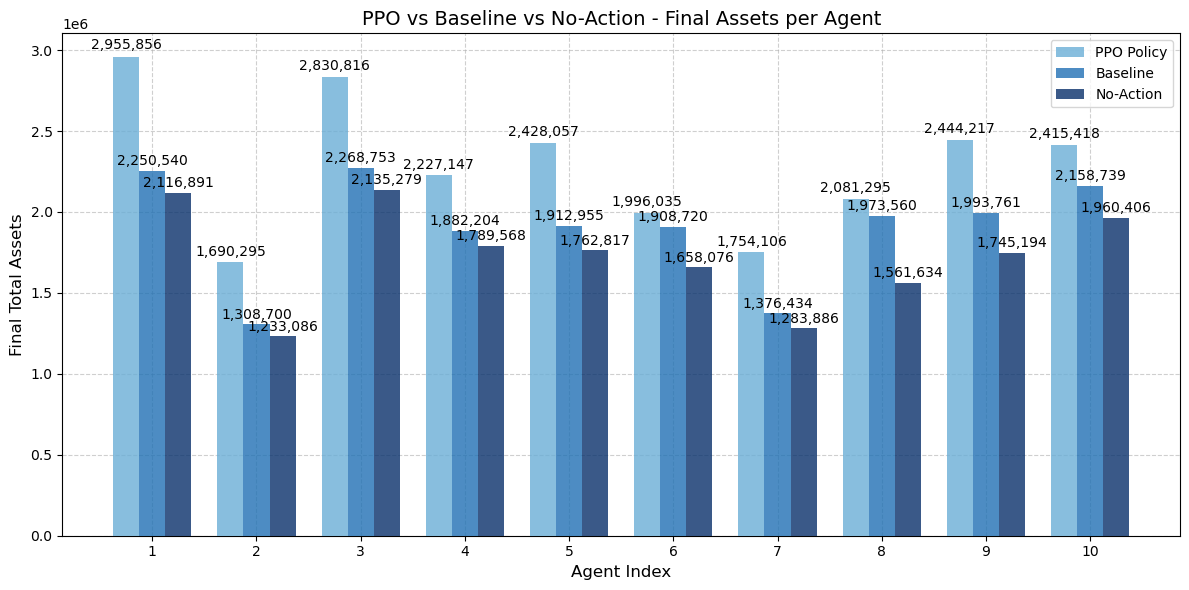

In [25]:
# 1️⃣ 生成 10 个 agent profile
agent_profiles = [generate_random_agent_profile(random_seed=100 + i) for i in range(10)]

# 2️⃣ 对每个 agent_profile，分别跑 PPO 策略、Baseline 策略、No-Action 策略
ppo_final_assets = []
baseline_final_assets = []
no_action_final_assets = []

for i, agent_profile in enumerate(agent_profiles):
    ###### PPO 策略 ######
    env = RealEstateEnv(
        all_properties=[deepcopy(p) for p in property_pool],
        agent_profile=agent_profile,
        growth_index=growth_index,
        max_inventory=10,
        candidate_top_k=20,
        scorer=RentalYieldScorer(),
        reward_scale=10.0,
        cash_bonus_scale=0.1
    )
    obs, _ = env.reset()
    for _ in range(200):
        state_flat, buy_cand, port = preprocess_obs(obs)
        with torch.no_grad():
            buy_scores, sell_scores, _ = policy_net(state_flat, buy_cand, port)
        buy_ids = [i for i, p in enumerate(obs['buy_candidates']) if p[0] > 0]
        sell_ids = [int(p[0]) for p in obs['portfolio'] if p[0] > 0]
        action, _ = sample_action(
            buy_scores.squeeze(0),
            sell_scores.squeeze(0),
            buy_candidates=buy_cand.squeeze(0),
            buy_indices=buy_ids,
            sell_ids=sell_ids,
            temperature=1.0,
            action_top_k=5
        )
        padded_sell = action['sell_house_ids'] + [0] * (env.max_inventory - len(action['sell_house_ids']))
        action_tensor = {
            'buy_index': np.array([action['buy_index']]),
            'sell_house_ids': np.array(padded_sell)
        }
        obs, _, done, _ = env.step(action_tensor)
        if done:
            break
    ppo_assets = obs['cash'][0] + sum(p[2] for p in obs['portfolio'] if p[0] > 0)
    ppo_final_assets.append(ppo_assets)

    ###### Baseline 策略 ######
    env = RealEstateEnv(
        all_properties=[deepcopy(p) for p in property_pool],
        agent_profile=agent_profile,
        growth_index=growth_index,
        max_inventory=10,
        candidate_top_k=20,
        scorer=RentalYieldScorer(),
        reward_scale=10.0,
        cash_bonus_scale=0.1
    )
    obs, _ = env.reset()
    state_flat, buy_cand, port = preprocess_obs(obs)
    with torch.no_grad():
        buy_scores, _, _ = policy_net(state_flat, buy_cand, port)
    buy_ids = [i for i, p in enumerate(obs['buy_candidates']) if p[0] > 0]
    top_idx = sorted(
        zip(buy_ids, buy_scores.squeeze(0).cpu().numpy()),
        key=lambda x: -x[1]
    )[0][0]
    action_tensor = {
        'buy_index': np.array([top_idx]),
        'sell_house_ids': np.array([0] * env.max_inventory)
    }
    obs, _, done, _ = env.step(action_tensor)
    while not done:
        action_tensor = {
            'buy_index': np.array([-1]),
            'sell_house_ids': np.array([0] * env.max_inventory)
        }
        obs, _, done, _ = env.step(action_tensor)
    baseline_assets = obs['cash'][0] + sum(p[2] for p in obs['portfolio'] if p[0] > 0)
    baseline_final_assets.append(baseline_assets)

    ###### No-Action 策略 ######
    env = RealEstateEnv(
        all_properties=[deepcopy(p) for p in property_pool],
        agent_profile=agent_profile,
        growth_index=growth_index,
        max_inventory=10,
        candidate_top_k=20,
        scorer=RentalYieldScorer(),
        reward_scale=10.0,
        cash_bonus_scale=0.1
    )
    obs, _ = env.reset()
    for _ in range(200):
        action_tensor = {
            'buy_index': np.array([-1]),
            'sell_house_ids': np.array([0] * env.max_inventory)
        }
        obs, _, done, _ = env.step(action_tensor)
        if done:
            break
    no_action_assets = obs['cash'][0] + sum(p[2] for p in obs['portfolio'] if p[0] > 0)
    no_action_final_assets.append(no_action_assets)

steps = np.arange(1, len(ppo_final_assets) + 1)  # agent index
bar_width = 0.25

# 设置配色
colors = plt.cm.Blues(np.linspace(0.5, 1, 3))  # 3组柱子

fig, ax = plt.subplots(figsize=(12, 6))

# PPO Policy
bars_ppo = ax.bar(steps - bar_width, ppo_final_assets, width=bar_width, color=colors[0], alpha=0.8, label='PPO Policy', zorder=3)

# Baseline
bars_baseline = ax.bar(steps, baseline_final_assets, width=bar_width, color=colors[1], alpha=0.8, label='Baseline', zorder=3)

# No-Action
bars_noaction = ax.bar(steps + bar_width, no_action_final_assets, width=bar_width, color=colors[2], alpha=0.8, label='No-Action', zorder=3)

# Title + labels
ax.set_title('PPO vs Baseline vs No-Action - Final Assets per Agent', fontsize=14)
ax.set_xlabel('Agent Index', fontsize=12)
ax.set_ylabel('Final Total Assets', fontsize=12)

# X-ticks
ax.set_xticks(steps)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Gridline 样式
ax.grid(axis='y', linestyle='--', alpha=0.6, zorder=0)
ax.grid(axis='x', linestyle='--', alpha=0.6, zorder=0)

# Legend
ax.legend()

def add_bar_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'{height:,.0f}',
                ha='center', va='bottom', fontsize=10)

add_bar_labels(bars_ppo)
add_bar_labels(bars_baseline)
add_bar_labels(bars_noaction)
plt.tight_layout()
plt.show()

C:\Users\huang\AppData\Local\Temp\ipykernel_30288\784974202.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load(policy_path, map_locat

Agent 1: PPO Avg Reward = 1.7054
Agent 1: Baseline Avg Reward = 1.5219
Agent 2: PPO Avg Reward = 2.4595
Agent 2: Baseline Avg Reward = 2.1267
Agent 3: PPO Avg Reward = 1.5769
Agent 3: Baseline Avg Reward = 1.3782
Agent 4: PPO Avg Reward = 1.7563
Agent 4: Baseline Avg Reward = 1.5821
Agent 5: PPO Avg Reward = 1.7092
Agent 5: Baseline Avg Reward = 1.4782
Agent 6: PPO Avg Reward = 1.8812
Agent 6: Baseline Avg Reward = 1.8239
Agent 7: PPO Avg Reward = 1.8872
Agent 7: Baseline Avg Reward = 1.5588
Agent 8: PPO Avg Reward = 2.0912
Agent 8: Baseline Avg Reward = 1.9993
Agent 9: PPO Avg Reward = 1.7751
Agent 9: Baseline Avg Reward = 1.6787
Agent 10: PPO Avg Reward = 1.9237
Agent 10: Baseline Avg Reward = 1.8407


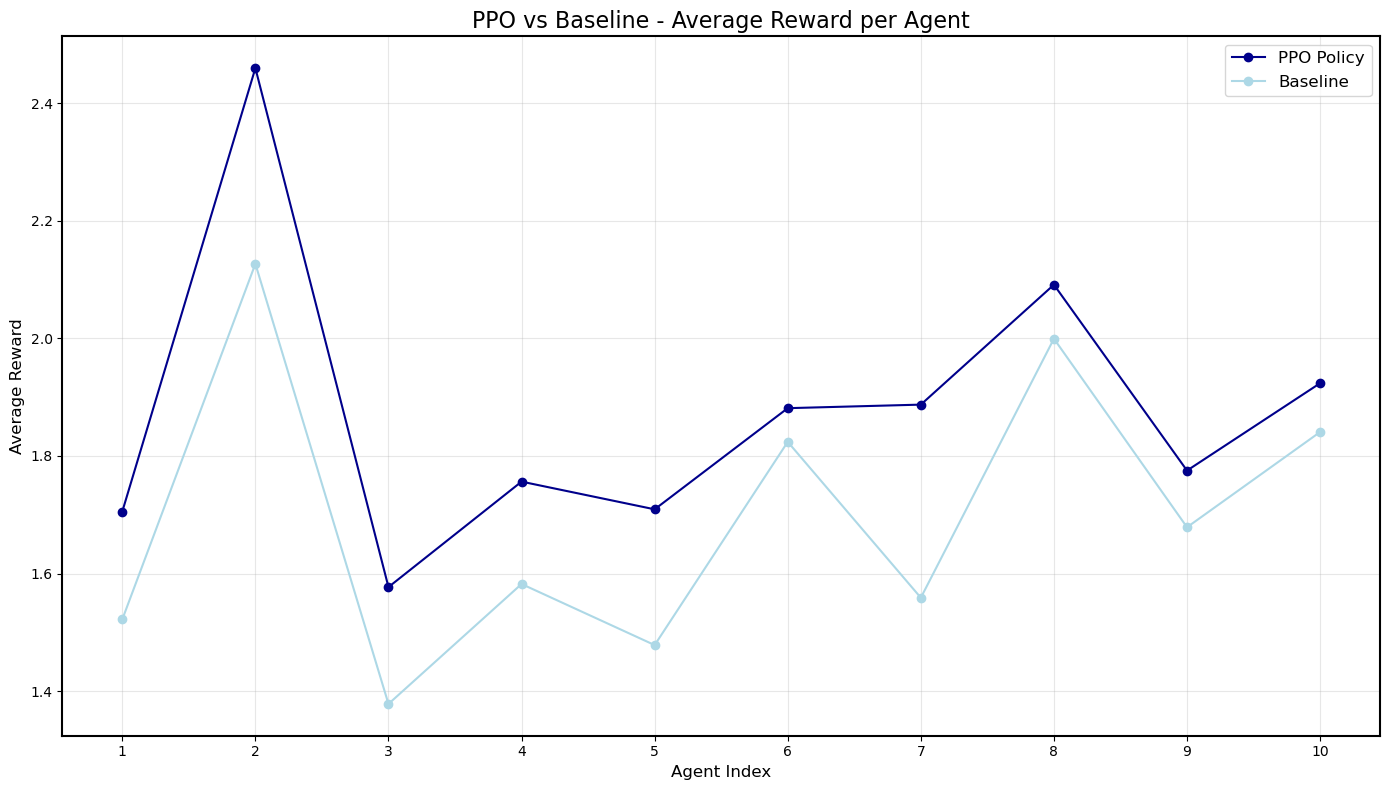

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# 加载 PPO 策略模型
def load_policy(policy_path: str):
    state_dim, buy_candidates_dim, portfolio_dim = 9, 10, 10
    policy_net = ActorCriticNet(state_dim, buy_candidates_dim, portfolio_dim)
    policy_net.load_state_dict(torch.load(policy_path, map_location="cpu"))
    policy_net.eval()
    return policy_net

# 生成 10 个 agent
agent_profiles = [generate_random_agent_profile(random_seed=100 + i) for i in range(10)]

# 加载 PPO 策略
policy_net = load_policy("ppo_policy.pth")

# 保存 PPO 和 baseline 策略 平均 reward per agent
ppo_avg_rewards = []
baseline_avg_rewards = []

# 逐个 agent 运行 PPO 和 baseline 策略
for i, agent_profile in enumerate(agent_profiles):
    ####### PPO 策略 #########
    env = RealEstateEnv(
        all_properties=[deepcopy(p) for p in property_pool],
        agent_profile=agent_profile,
        growth_index=growth_index,
        max_inventory=10,
        candidate_top_k=20,
        scorer=RentalYieldScorer(),
        reward_scale=10.0,
        cash_bonus_scale=0.1
    )
    obs, _ = env.reset()

    rewards = []

    for _ in range(200):
        state_flat, buy_cand, port = preprocess_obs(obs)
        with torch.no_grad():
            buy_scores, sell_scores, _ = policy_net(state_flat, buy_cand, port)
        buy_ids = [i for i, p in enumerate(obs['buy_candidates']) if p[0] > 0]
        sell_ids = [int(p[0]) for p in obs['portfolio'] if p[0] > 0]
        action, _ = sample_action(
            buy_scores.squeeze(0),
            sell_scores.squeeze(0),
            buy_candidates=buy_cand.squeeze(0),
            buy_indices=buy_ids,
            sell_ids=sell_ids,
            temperature=1.0,
            action_top_k=5
        )
        padded_sell = action['sell_house_ids'] + [0] * (env.max_inventory - len(action['sell_house_ids']))
        action_tensor = {
            'buy_index': np.array([action['buy_index']]),
            'sell_house_ids': np.array(padded_sell)
        }
        obs, reward, done, _ = env.step(action_tensor)

        rewards.append(reward)

        if done:
            break

    avg_reward = np.mean(rewards) if rewards else 0.0
    ppo_avg_rewards.append(avg_reward)
    print(f"Agent {i+1}: PPO Avg Reward = {avg_reward:.4f}")

    ####### Baseline 策略 #########
    env = RealEstateEnv(
        all_properties=[deepcopy(p) for p in property_pool],
        agent_profile=agent_profile,
        growth_index=growth_index,
        max_inventory=10,
        candidate_top_k=20,
        scorer=RentalYieldScorer(),
        reward_scale=10.0,
        cash_bonus_scale=0.1
    )
    obs, _ = env.reset()

    rewards = []

    # 第一年买 top-1
    state_flat, buy_cand, port = preprocess_obs(obs)
    with torch.no_grad():
        buy_scores, _, _ = policy_net(state_flat, buy_cand, port)
    buy_ids = [i for i, p in enumerate(obs['buy_candidates']) if p[0] > 0]
    top_idx = sorted(
        zip(buy_ids, buy_scores.squeeze(0).cpu().numpy()),
        key=lambda x: -x[1]
    )[0][0]
    action_tensor = {
        'buy_index': np.array([top_idx]),
        'sell_house_ids': np.array([0] * env.max_inventory)
    }
    obs, reward, done, _ = env.step(action_tensor)
    rewards.append(reward)

    # 持有到底
    while not done:
        action_tensor = {
            'buy_index': np.array([-1]),
            'sell_house_ids': np.array([0] * env.max_inventory)
        }
        obs, reward, done, _ = env.step(action_tensor)
        rewards.append(reward)

    avg_reward_baseline = np.mean(rewards) if rewards else 0.0
    baseline_avg_rewards.append(avg_reward_baseline)
    print(f"Agent {i+1}: Baseline Avg Reward = {avg_reward_baseline:.4f}")

# 画图
steps = list(range(1, len(ppo_avg_rewards) + 1))
# ✅ 改为标准折线图格式（你的风格）
plt.figure(figsize=(14, 8))

# 折线
plt.plot(steps, ppo_avg_rewards, label='PPO Policy', marker='o', linestyle='-', color='darkblue')
plt.plot(steps, baseline_avg_rewards, label='Baseline', marker='o', linestyle='-', color='lightblue')

# 标题与标签
plt.title("PPO vs Baseline - Average Reward per Agent", fontsize=16)
plt.xlabel("Agent Index", fontsize=12)
plt.ylabel("Average Reward", fontsize=12)

# 刻度
plt.xticks(steps, fontsize=10)
plt.yticks(fontsize=10)

# 图例
plt.legend(fontsize=12)

# 网格样式
plt.grid(alpha=0.3)

# 坐标轴边框样式
for side in ['top', 'right', 'left', 'bottom']:
    plt.gca().spines[side].set_color('black')
    plt.gca().spines[side].set_linewidth(1.5)

plt.tight_layout()
plt.show()